In [104]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [105]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [106]:
df = pd.read_csv("data/my_horizon_data_all.csv", dtype={"subject": str})

# files = [
#     "data/my_horizon_data.csv",
#     "data/my_horizon_data_0919.csv",
# ]
# df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [107]:
df.head()

,subject,block,m1,m2,uc,gameLength,age,gender,trial,reward,...,rt0,rt1,rt2,rt3,rt4,rt5,rt6,rt7,rt8,rt9
0,0,0,40,36,1,6,18,-99,0,42,...,184.143661,4.635614,1.122532,2.833540,2.738855,5.263696,5.763985,1.940346,0.937745,2.472841
1,0,1,60,48,0,6,18,-99,0,67,...,1.184903,1.013671,1.305989,8.874533,2.708196,2.426142,1.115581,1.370487,1.103393,1.046302
2,0,2,40,36,0,6,18,-99,0,37,...,0.832413,0.468084,0.566725,0.445963,1.810017,1.325654,0.892086,0.780645,1.881181,0.576540
3,0,3,40,48,0,1,18,-99,0,58,...,0.830383,0.553779,0.817720,1.686227,0.910277,NaN,NaN,NaN,NaN,NaN
4,0,4,40,10,0,1,18,-99,0,4,...,0.663673,1.049479,0.692706,3.581879,4.616839,NaN,NaN,NaN,NaN,NaN


In [108]:
# same as sklearn 

seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = 'c4'

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]

print(type(X_seq))
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)
print(type(X_seq_train))

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())


# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)



# X_seq_train = X_seq_train.to_numpy()
# X_seq_test = X_seq_test.to_numpy()
# X_static_train = X_static_train.to_numpy()
# X_static_test = X_static_test.to_numpy()

print("After scaling:")
print(f'X_seq_train {X_seq_train[0]}')
print(f'X_static_train {X_static_train[0]}')
print(f'y_train {y_train.iloc[0]}')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
--- Feature Data (X) ---
     r0   c0    r1   c1    r2   c2    r3   c3
0  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
1  67.0  0.0  57.0  1.0  56.0  0.0  50.0  1.0
2  37.0  1.0  48.0  0.0  23.0  0.0  39.0  1.0
3  58.0  1.0  51.0  0.0  28.0  0.0  47.0  1.0
4   4.0  1.0  30.0  0.0  11.0  1.0  37.0  0.0
   gameLength  uc
0           6   1
1           6   0
2           6   0
3           1   0
4           1   0

--- Target Data (y) ---
0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: c4, dtype: float64
After scaling:
X_seq_train [-0.38649261  0.96221224  0.20634578 -1.00385279  1.15776823  1.03427041
  0.33675682  1.00923939]
X_static_train [0.999503   1.37599616]
y_train 0.0


In [109]:
SEQ_LEN = seq_features.__len__() // 4 
print(f"SEQ_LEN: {SEQ_LEN}")

SEQ_LEN: 2


In [110]:
feature_order_test = np.array(seq_features).reshape(-1, 4, SEQ_LEN)
print(feature_order_test)

[[['r0' 'c0']
  ['r1' 'c1']
  ['r2' 'c2']
  ['r3' 'c3']]]


In [111]:
print(X_seq_train.shape)
print(X_seq_test.shape)
print(type(X_seq_train))
print(type(y_train))

(136788, 8)
(34197, 8)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [112]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, SEQ_LEN)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, SEQ_LEN)
print(X_seq_test.shape)
print(type(X_seq_test))

(136788, 4, 2)
<class 'numpy.ndarray'>
[[-0.38649261  0.96221224]
 [ 0.20634578 -1.00385279]
 [ 1.15776823  1.03427041]
 [ 0.33675682  1.00923939]]
(34197, 4, 2)
<class 'numpy.ndarray'>


convert to tensor for pytorch

In [113]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [114]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [115]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [116]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [117]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [118]:
class RNN(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=64, output_size=2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(seq_input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, h_n = self.rnn(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output


In [119]:
class LSTM(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=128, output_size=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 64), # combine static inputs
            nn.GELU(),
            nn.Linear(64, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, (h_n, c_n) = self.lstm(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [120]:
class GRU(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=64, output_size=2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [121]:
class TinyGRU(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=2, output_size=2):
        super(TinyGRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 2), # combine static inputs
            nn.ReLU(),
            nn.Linear(2, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [122]:
class PositionalEncodingSin(nn.Module):
    def __init__(self, d_model, max_len=4):
        super(PositionalEncodingSin, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return x

In [123]:
class TransformerEncoderPositionalEncoding(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=64, output_size=2):
        super(TransformerEncoderPositionalEncoding, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncodingSin(d_model=hidden_size, max_len=4)

        self.transformer = nn.TransformerEncoderLayer( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            d_model=hidden_size, 
            nhead=4, 
            dropout=0.0,
            dim_feedforward=128,
            activation="relu",
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans = self.transformer(x_encoded) # (batch, 4, hidden_size)
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [124]:
class SelfAttentionOnly(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=64, output_size=2):
        super(SelfAttentionOnly, self).__init__()
        self.input_fc = nn.Linear(seq_input_size, hidden_size)
        self.pos_encoder = PositionalEncodingSin(d_model=hidden_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=hidden_size, 
            num_heads=8, 
            dropout=0.0,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        x_encoded = self.pos_encoder(x_seq_proj)
        x_trans, _ = self.attn(x_encoded, x_encoded, x_encoded) # (batch, 4, hidden_size)
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

In [125]:
class TinyAttentionNoProj(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=2, output_size=2):
        super(TinyAttentionNoProj, self).__init__()
        # self.input_fc = nn.Linear(seq_input_size, hidden_size)
        # self.pos_encoder = PositionalEncodingSin(d_model=seq_input_size, max_len=4)

        self.attn = nn.MultiheadAttention( # (batch_size, seq_len=4, feature_dim (projected to higher dim))
            embed_dim=seq_input_size, 
            num_heads=1, 
            dropout=0.0,
            batch_first=True
        )
        # self.mlp = nn.Sequential(
        #     nn.Linear(seq_input_size, seq_input_size),
        #     nn.ReLU()
        # )

        self.fc = nn.Sequential(
            nn.Linear(seq_input_size + static_input_size, 1), # combine static inputs
            nn.ReLU(),
            nn.Linear(1, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        # x_seq_proj = self.input_fc(seq_x) # (batch, 4, 3) -> (batch, 4, hidden_size)
        # x_encoded = self.pos_encoder(seq_x)
        x_trans, _ = self.attn(seq_x, seq_x, seq_x) # (batch, 4, hidden_size)

        # x_trans = self.mlp(x_trans)
        
        x_final = x_trans[:, -1, :]  # take the output of the last time step
        # concatenate RNN output with static features
        combined = torch.cat((x_final, static_x), dim=1)
        output = self.fc(combined)
        return output

# train / eval

In [126]:
def train(model, train_loader, criterion, optimizer, device): 
    model.train()
    train_loss = 0.0
    correct = 0
    total = len(train_loader)

    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seq_inputs, static_inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        train_loss += loss.item() * labels.size(0)
        correct += (preds == labels).sum().item()

    avg_loss = train_loss / total
    accuracy = correct / total
    return accuracy, avg_loss


def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total_loss = 0
    total = len(test_loader.dataset)
    
    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            
            logits = model(seq_inputs, static_inputs)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total_loss += loss.item() * labels.size(0)


    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

In [127]:
def train_and_evaluate(model, train_loader, criterion, optimizer, device, epochs):
    train_loss_prog, train_acc_prog = [], []

    test_loss_prog, test_acc_prog = [], []

    test_acc_h1_prog, test_loss_h1_prog = [], []
    test_acc_h6_prog, test_loss_h6_prog = [], []

    epochs_without_improvement = 0 # for early stopping
    best_loss = float('inf')
    PATIENCE = 5
    final_epoch = epochs

    for epoch in range(epochs):
        train_acc, train_loss = train(model, train_loader, criterion, optimizer, device)

        test_acc, test_loss = test(model, test_loader, criterion, device)
        test_acc_h1, test_loss_h1 = test(model, test_loader_h1, criterion, device)
        test_acc_h6, test_loss_h6 = test(model, test_loader_h6, criterion, device)
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: Loss: {test_loss:.4f} | overall: {test_acc:.4f} | H1 {test_acc_h1:.4f} | H6 {test_acc_h6:.4f}")

        train_acc_prog.append(train_acc)
        train_loss_prog.append(train_loss)

        test_loss_prog.append(test_loss)
        test_acc_prog.append(test_acc)

        test_acc_h1_prog.append(test_acc_h1)
        test_loss_h1_prog.append(test_loss_h1)

        test_acc_h6_prog.append(test_acc_h6)
        test_loss_h6_prog.append(test_loss_h6)

        # early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement > PATIENCE: 
            print(f"Early stopping triggered: epoch {epoch+1} best_loss {best_loss:.4f}")
            final_epoch = epoch+1
            break

    return train_loss_prog, train_acc_prog, test_loss_prog, test_acc_prog, test_acc_h1_prog, test_loss_h1_prog, test_acc_h6_prog, test_loss_h6_prog, final_epoch

# running experiment

## single model

In [128]:
# model = TinyAttentionNoProj().to(device)
# print(model)

In [129]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# epochs = 100
# loss_prog, acc_prog, acc_h1_prog, acc_h6_prog, final_epoch = train_and_evaluate(model, train_loader, criterion, optimizer, device, epochs=epochs)

## multiple models

In [130]:
model_dict = {
    "RNN": RNN().to(device),
    "LSTM": LSTM().to(device),
    "GRU": GRU().to(device),
    "TinyGRU": TinyGRU().to(device),
    "Transformer": TransformerEncoderPositionalEncoding().to(device),
    "SelfAttention": SelfAttentionOnly().to(device),
    # "TinyAttentionNoProj": TinyAttentionNoProj().to(device),
}

In [131]:
epochs = 100
for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss_prog, train_acc_prog, test_loss_prog, test_acc_prog, test_acc_h1_prog, test_loss_h1_prog, test_acc_h6_prog, test_loss_h6_prog, final_epoch = train_and_evaluate(model, train_loader, criterion, optimizer, device, epochs=epochs)
    model_dict[model_name] = {
        "model": model,
        "train_loss_prog": train_loss_prog,
        "train_acc_prog": train_acc_prog,
        "test_loss_prog": test_loss_prog,
        "test_acc_prog": test_acc_prog,
        "test_acc_h1_prog": test_acc_h1_prog,
        "test_loss_h1_prog": test_loss_h1_prog,
        "test_acc_h6_prog": test_acc_h6_prog,
        "test_loss_h6_prog": test_loss_h6_prog,
        "final_epoch": final_epoch
    }


Training model: RNN
Epoch 1: Loss: 0.5045 | overall: 0.7757 | H1 0.8124 | H6 0.7390
Epoch 10: Loss: 0.4954 | overall: 0.7758 | H1 0.8136 | H6 0.7382
Epoch 20: Loss: 0.4961 | overall: 0.7752 | H1 0.8139 | H6 0.7366
Early stopping triggered: epoch 21 best_loss 0.4954

Training model: LSTM
Epoch 1: Loss: 0.5067 | overall: 0.7759 | H1 0.8139 | H6 0.7380
Epoch 10: Loss: 0.4928 | overall: 0.7786 | H1 0.8153 | H6 0.7421
Epoch 20: Loss: 0.4923 | overall: 0.7777 | H1 0.8160 | H6 0.7396
Early stopping triggered: epoch 25 best_loss 0.4916

Training model: GRU
Epoch 1: Loss: 0.5024 | overall: 0.7729 | H1 0.8069 | H6 0.7390
Epoch 10: Loss: 0.4953 | overall: 0.7782 | H1 0.8154 | H6 0.7410
Early stopping triggered: epoch 14 best_loss 0.4919

Training model: TinyGRU
Epoch 1: Loss: 0.5274 | overall: 0.7630 | H1 0.7912 | H6 0.7350
Epoch 10: Loss: 0.5177 | overall: 0.7669 | H1 0.7993 | H6 0.7346
Epoch 20: Loss: 0.5153 | overall: 0.7708 | H1 0.8054 | H6 0.7363
Epoch 30: Loss: 0.5137 | overall: 0.7690 | H

# plotting

In [132]:
import matplotlib.pyplot as plt

## single model

In [133]:
# # plot training and testing loss
# plt.figure(figsize=(10, 5))
# plt.plot(range(epochs), loss_prog, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss over epochs')
# plt.legend()
# plt.show()

In [134]:
# # plot testing accuracy
# def plot_accuracy(accuracy_progress_list):
#     plt.figure(figsize=(10, 5))
#     for label, acc in accuracy_progress_list:
#         plt.plot(range(epochs), acc, label=label)
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy (%)')
#     plt.title('Test Accuracy over epochs')
#     plt.legend()
#     plt.show()

# plot_accuracy([('test accuracy', acc_prog)])

In [135]:
# plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])

## multiple models

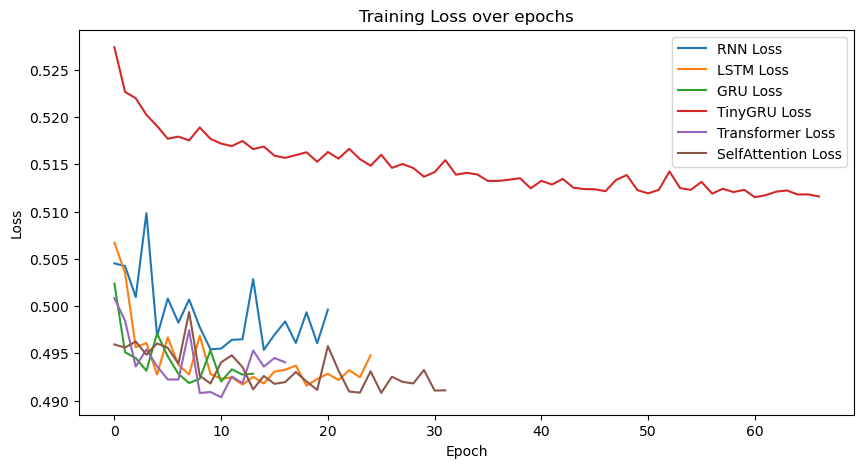

In [136]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
for model_name, data in model_dict.items():
    loss_prog = data["test_loss_prog"]
    final_epoch = data["final_epoch"]
    plt.plot(range(final_epoch), loss_prog, label=f'{model_name} Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

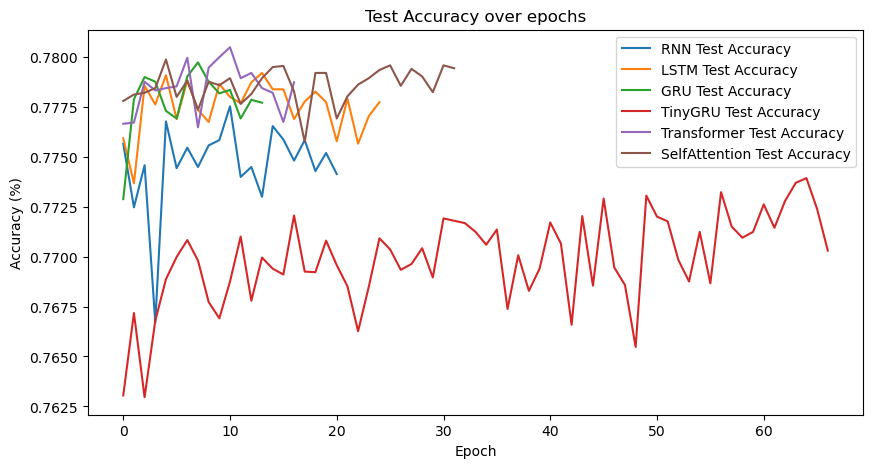

In [137]:
# plot testing accuracy
plt.figure(figsize=(10, 5))
for model_name, data in model_dict.items():
    acc_prog = data["test_acc_prog"]
    final_epoch = data["final_epoch"]
    plt.plot(range(final_epoch), acc_prog, label=f'{model_name} Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs')
plt.legend()
plt.show()


In [138]:
n = len(model_dict)

# Two color ramps
blue_cmap = plt.get_cmap('Blues')
red_cmap  = plt.get_cmap('Reds')

# helper to pick a shade between lo..hi in the colormap
def shade(cmap, i, n, lo=0.35, hi=0.85):
    if n <= 1:
        t = (lo+hi)/2
    else:
        t = lo + (hi - lo) * (i / (n - 1))
    return cmap(t)

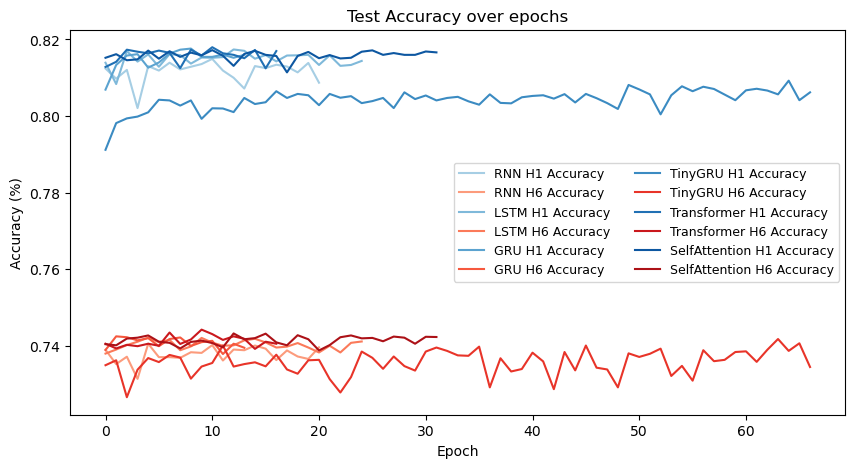

In [139]:
# plot testing accuracy h1 vs h6
plt.figure(figsize=(10, 5))
for i, (model_name, data) in enumerate(model_dict.items()):
    acc_h1_prog = data["test_acc_h1_prog"]
    acc_h6_prog = data["test_acc_h6_prog"]
    final_epoch = data["final_epoch"]
    plt.plot(range(final_epoch), acc_h1_prog, label=f'{model_name} H1 Accuracy', color=shade(blue_cmap, i, n))
    plt.plot(range(final_epoch), acc_h6_prog, label=f'{model_name} H6 Accuracy', color=shade(red_cmap, i, n))
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs')
plt.legend(
    ncol=2,      
    fontsize=9, 
)
plt.show()

## error bar

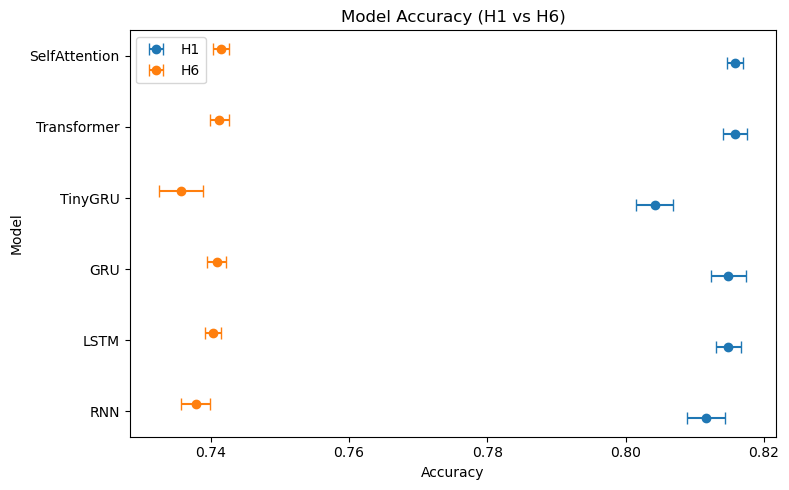

In [141]:
h1_means = []
h6_means = []

h1_stds = []
h6_stds = []

for model_name, data in model_dict.items():
    acc_h1 = data["test_acc_h1_prog"]
    acc_h6 = data["test_acc_h6_prog"]

    h1_means.append(np.mean(acc_h1))
    h6_means.append(np.mean(acc_h6))
    h1_stds.append(np.std(acc_h1))
    h6_stds.append(np.std(acc_h6))


names = list(model_dict.keys())
y_pos = np.arange(len(names))
fig, ax = plt.subplots(figsize=(8, 5))

# H1
ax.errorbar(h1_means, y_pos - 0.1, xerr=h1_stds, fmt='o', color='tab:blue',
            label="H1", capsize=4)

# H6
ax.errorbar(h6_means, y_pos + 0.1, xerr=h6_stds, fmt='o', color='tab:orange',
            label="H6", capsize=4)

ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.set_xlabel("Accuracy")
ax.set_ylabel("Model")
ax.set_title("Model Accuracy (H1 vs H6)")
ax.legend()

plt.tight_layout()
plt.show()